In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from utils_fns import *
from tqdm import tqdm
import time

### Define 2d rosenbrock and its derivatives

In [2]:
# 2d Rosenbrock function
def f(x, a=1.0, b=100.0):
    '''
    x: array of row vector of size 2
    '''
    # print(x)
    return (a - x[:,0])**2 + b * (x[:,1] - x[:,0]**2)**2

def df(x, a=1.0, b=100.0):
    '''
    for 2d x
    '''
    dx1 = -2*(a-x[:,0]) - 4*b*x[:,0] * (x[:,1]-x[:,0]**2)
    dx2 = 2*b*(x[:,1] - x[:,0]**2)
    return torch.tensor([dx1, dx2]).unsqueeze(0)

def hf(x, a=1.0, b=100.0):
    dx11 = 2 - 4*b*x[:,1] + 12*b*x[:,0]
    dx12 = -4*b*x[:,0]
    dx22 = 2*b
    
    dx11 = dx11.view(-1,1)
    dx12 = dx12.view(-1,1)
    first_column = torch.stack((dx11, dx12), dim=-1)
    second_column = torch.stack((dx12, torch.full_like(dx12, dx22)), dim=-1)
    hessian = torch.stack((first_column, second_column), dim=-2)
    return hessian.squeeze()

#### Draw 2d rosenbrock

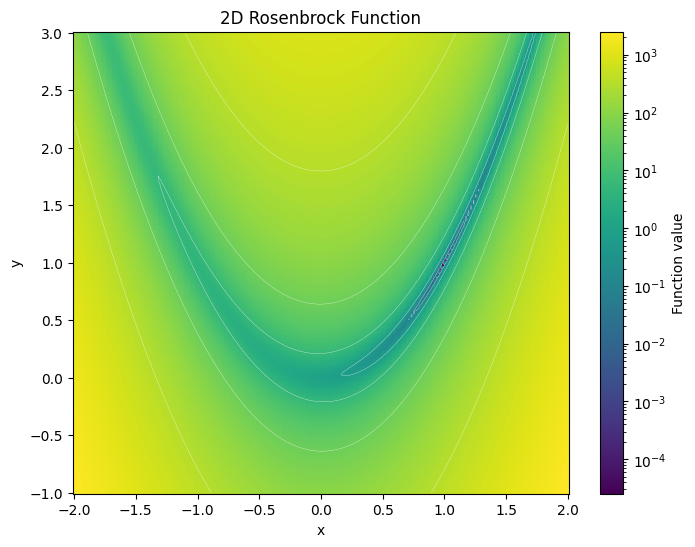

In [3]:
grid_size = 200
x1 = np.linspace(-2, 2, grid_size)
x2 = np.linspace(-1, 3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)

y = f(x).reshape((grid_size,grid_size))

fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolor(X1, X2, y, norm=colors.LogNorm(vmin=y.min(), vmax=y.max()))
contour_levels = np.logspace(np.log10(y.min()), np.log10(y.max()), 10)
contours = ax.contour(X1, X2, y, levels=contour_levels, colors='white', linewidths=0.2)
# ax.clabel(contours, inline=True, fontsize=8)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Function value')
ax.set_title('2D Rosenbrock Function')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [6]:
def draw_dir(dirs, ax):
    '''
    In forms of nx2x2, with starting point and direction
    '''
    if len(dirs.shape) == 2:
        dirs = np.expand_dims(dirs, axis=0)
    for dir in dirs:
        start_point = np.array([dir[0,0], dir[0,1]])
        direction = np.array([dir[1,0], dir[1,1]])
        end_point = direction/np.linalg.norm(direction)/3 + start_point
        # print("draw_dir: ", start_point, end_point)
        ax.annotate('', xy=end_point, xytext=start_point,
                    arrowprops=dict(arrowstyle='->', lw=1.5, color='blue'))

In [7]:
def adam(f, x0, **f_args):
    hparams = f_args['opt_args']
    optim = torch.optim.Adam([x0], lr=hparams['learning_rate'])
    x_list = []
    x_copy = x0.clone().squeeze().detach().numpy()
    x_list.append(x_copy)
    for j in range(hparams['epochs']):
        # print(x_list)
        optim.zero_grad()

        loss = f(x0.unsqueeze(0))
        loss.backward()

        optim.step()
        x_copy = x0.clone().squeeze().detach().numpy()
        x_list.append(x_copy)
    
    return np.array(x_list)

In [80]:
def is_positive_definite(matrix):
    """
    Check if a matrix is positive definite using Cholesky factorization.
    
    Parameters:
    matrix (np.ndarray): The input matrix to check.
    
    Returns:
    bool: True if the matrix is positive definite, False otherwise.
    """
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False


def newton(f, x0, max_iter, diff, hess, rate, tol=1e-5, modified = True):
    
    lr = rate
    x_list = []
    x = x0.unsqueeze(0)
    x_copy = x0.clone().squeeze().detach().numpy()
    x_list.append(x_copy)
    
    for i in range(max_iter):
        
        deriv = diff(x).T
        hessian = hess(x)
        if is_positive_definite(hessian) or not modified:
            x = x - lr*(torch.pinverse(hessian)@deriv).T
        else:
            x = x - lr*deriv.T/np.linalg.norm(deriv)
        x_copy = x.clone().squeeze().detach().numpy()
        x_list.append(x_copy)
        if len(x_list) >= 2:
            if np.sum(np.sqrt((x_list[-1] - x_list[-2])**2)) < tol:
                print("converged at: ", i)
                break
        
    return x, np.array(x_list)

    

In [131]:
def NCG(f, x0, max_iter, diff, hess, **f_args):
    """
    Non-linear CG for minimizing the SmoothFn.
    x0: initial guess as a row vector
    """
    tol = f_args['opt_args']['tol']
    NR_max_iter = f_args['opt_args']['NR_max_iter']
    NR_tol = f_args['opt_args']['NR_tol']
    recompute = f_args['opt_args']['recompute']
    grad_dir = f_args['opt_args']['grad_dir']
    
    x_list = []
    d_list = []
    x = x0.unsqueeze(0)
    x_copy = x.clone().squeeze().detach().numpy()
    x_list.append(x_copy)
    k = 0
    r = -diff(x).T # r should be column vector
    d = r
    dir = [x_copy,d.clone().squeeze().detach().numpy()]
    d_list.append(dir)
    delta_new = (r.T@r).item()
    tolerance = tol**2 * delta_new # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        delta_d = d.T@d
        for j in range(NR_max_iter): # newton-ralph approximation
            print(x)
            hessian = hess(x)

            denom = d.T@hessian@d
            assert denom != 0, "try a new starting point"
            # if i == 0:
            #     assert denom != 0, "try a new starting point"
            # elif denom == 0:
            #     d = r = -diff(x).T
            #     x=x0.unsqueeze(0)
            #     break
            
            if denom < 0 and grad_dir:
                denom = -denom*1.3#torch.norm(diff(x))
            alpha = -(diff(x)@d / denom).item()
            x = x + alpha*d.squeeze()
            # print(j)
            # print("hessian: ", torch.det(hessian))
            # print("diff: ", diff(x))
            # print("d: ", d)
            # print("product: ", diff(x)@d)
            # print("denom: ", denom)
            # print("alpha: ", alpha)
            # print("x: ",x)
            # print("\n")
            if alpha**2 * delta_d <= NR_tol:
                break
        x_copy = x.clone().squeeze().detach().numpy()
        x_list.append(x_copy)
        r = -diff(x).T
        delta_old = delta_new
        delta_new = r.T@r
        beta = delta_new/delta_old
        d = r + beta*d
        dir = [x_copy,d.clone().squeeze().detach().numpy()]
        d_list.append(dir)
        if k>=recompute or r.T@d <=0: # restart whenever a search direction is computed that is not descent direction
            k = 0
            d = r

        if delta_new <= tolerance:
            num_iter = i+1
            print("Converged at ", i+1)
            break
        
    return x, r, num_iter, np.array(x_list), np.array(d_list)



#### NCG with analytical hessian and gradients

In [70]:
hparams = {'epochs': 1500,
           'tol': 1e-6, # tolerance for CG
           'learning_rate': 1e-2,
           'NR_max_iter': 200, # max iter for NR line search in CG
           'NR_tol': 1e-5, # tolerance for NR line search in CG
           'recompute': 10, # recompute the exact residual every n iterations
           'grad_dir': True # use gradient direction
           }

# --------------- run optimization
max_iter = hparams['epochs']
# x = torch.tensor([1.3,1.9]).requires_grad_(True)
x = torch.tensor([-1.5, 1.5]).requires_grad_(True)
# x = torch.tensor([0.0, 1.0]).requires_grad_(True)
x, _, _, x_list, d_list = NCG(f, x, max_iter, df, hf, opt_args=hparams)

Converged at  760


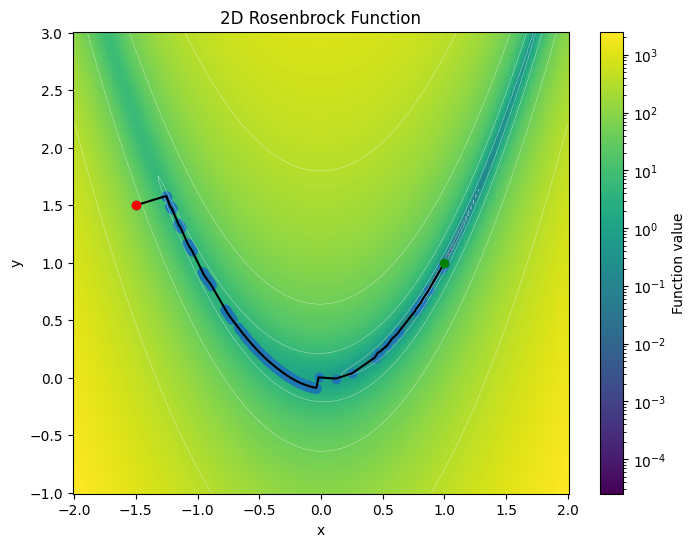

tensor([[0.9999, 0.9998]], grad_fn=<AddBackward0>)


In [71]:
def draw_traj(x_list, ax):
    # the rosenbrock function
    pcm = ax.pcolor(X1, X2, y, norm=colors.LogNorm(vmin=y.min(), vmax=y.max()))
    contour_levels = np.logspace(np.log10(y.min()), np.log10(y.max()), 10)
    contours = ax.contour(X1, X2, y, levels=contour_levels, colors='white', linewidths=0.2)
    # the trajectory
    line1, = ax.plot(x_list[:,0], x_list[:,1], color='black', label='CG Trajectory')
    ax.scatter(x_list[:,0], x_list[:,1])
    ax.scatter(x_list[0,0], x_list[0,1], color='red', zorder=6, label='Start')
    ax.scatter(x_list[-1,0], x_list[-1,1], color='green', zorder=5, label='End')
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label('Function value')
    ax.set_title('2D Rosenbrock Function')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
fig, ax = plt.subplots(figsize=(8, 6))
# draw_dir(d_list, ax)
draw_traj(x_list, ax)
plt.show()
print(x)

#### Adam with analytical gradients 

In [12]:
hparams = {'epochs': 1500,
           'tol': 1e-6, # tolerance for CG
           'learning_rate': 1e-1,
           'NR_max_iter': 200, # max iter for NR line search in CG
           'NR_tol': 1e-4, # tolerance for NR line search in CG
           'recompute': 2, # recompute the exact residual every n iterations
           }
x = torch.tensor([-1.0, 1.5]).requires_grad_(True)
gd_list = adam(f, x, opt_args=hparams)

(1501, 2)


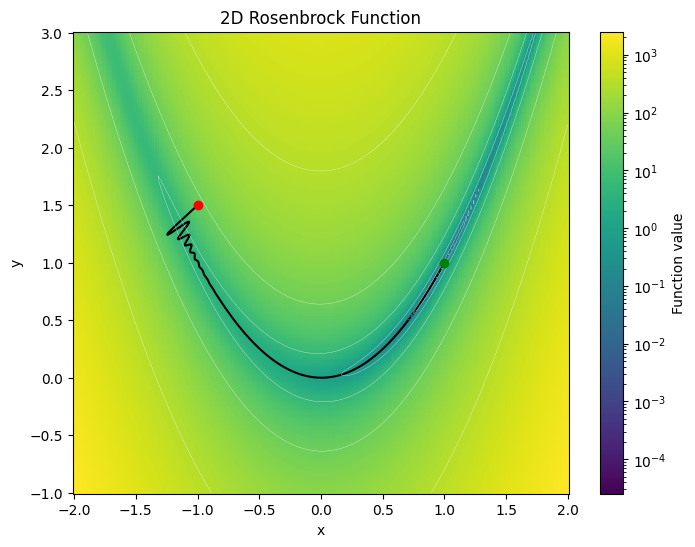

[[-1.          1.5       ]
 [-1.1         1.4       ]
 [-1.1900507   1.3109233 ]
 ...
 [ 0.99995047  0.99990064]
 [ 0.999951    0.9999018 ]
 [ 0.9999515   0.99990296]]


In [13]:
print(gd_list.shape)
fig, ax = plt.subplots(figsize=(8, 6))
line1, = ax.plot(gd_list[:,0], gd_list[:,1],color='black', label='CG Trajectory')
pcm = ax.pcolor(X1, X2, y, norm=colors.LogNorm(vmin=y.min(), vmax=y.max()))
contour_levels = np.logspace(np.log10(y.min()), np.log10(y.max()), 10)
contours = ax.contour(X1, X2, y, levels=contour_levels, colors='white', linewidths=0.2)

ax.scatter(gd_list[0,0], gd_list[0,1], color='red', zorder=6, label='Start')
ax.scatter(gd_list[-1,0], gd_list[-1,1], color='green', zorder=5, label='End')

# ax.clabel(contours, inline=True, fontsize=8)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Function value')
ax.set_title('2D Rosenbrock Function')
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.legend(handles=[line1])

plt.show()
print(gd_list)

#### Adam with MC blur

In [ ]:
def adam_blurred(f, x0, **f_args):
    hparams = f_args['opt_args']
    optim = torch.optim.Adam([x0], lr=hparams['learning_rate'])
    x_list = []
    x_copy = x0.squeeze().detach().numpy()
    x_list.append(x_copy)
    for j in range(hparams['epochs']):
        optim.zero_grad()

        loss = f(x0.unsqueeze(0))
        loss.backward()

        optim.step()
        x_copy = x0.clone().squeeze().detach().numpy()
        x_list.append(x_copy)
    
    return np.array(x_list)

#### Adam with interval blur

#### CG with interval blur

#### newton

In [81]:
x = torch.tensor([-1, 0.0]).requires_grad_(True)
max_iter = 5000
x, x_list = newton(f, x, max_iter, df, hf, rate = 1, modified=False) 
print(x)

tensor([[-4.2039, 17.6729]], grad_fn=<SubBackward0>)


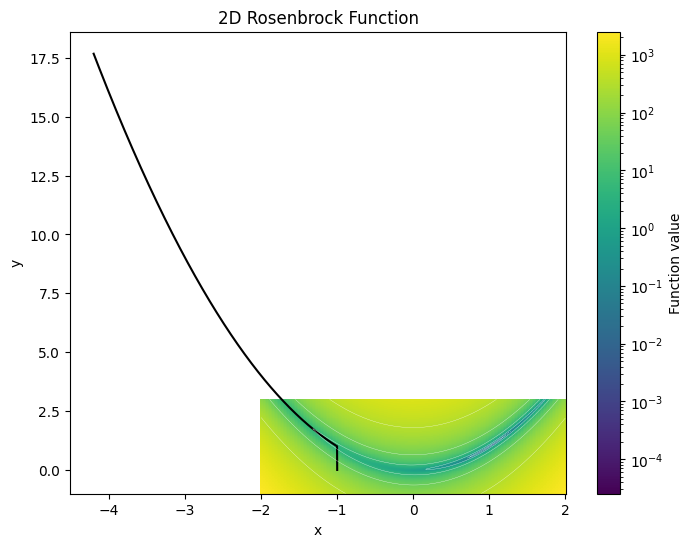

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))
line1, = ax.plot(x_list[:,0], x_list[:,1],color='black', label='CG Trajectory')
pcm = ax.pcolor(X1, X2, y, norm=colors.LogNorm(vmin=y.min(), vmax=y.max()))
contour_levels = np.logspace(np.log10(y.min()), np.log10(y.max()), 10)
contours = ax.contour(X1, X2, y, levels=contour_levels, colors='white', linewidths=0.2)
# ax.clabel(contours, inline=True, fontsize=8)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Function value')
ax.set_title('2D Rosenbrock Function')
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.legend(handles=[line1])

plt.show()

In [85]:
import time
samples = 20
res_list = np.zeros((samples, 3, 2))
time_list = np.zeros((samples, 3))
for i in range(samples):
    x = torch.tensor([np.random.uniform(-2, 1), np.random.uniform(-1, 2)]).requires_grad_(True)
    print(x)
    # hparams = {'epochs': 1500,
    #        'tol': 1e-6, # tolerance for CG
    #        'learning_rate': 1e-2,
    #        'NR_max_iter': 200, # max iter for NR line search in CG
    #        'NR_tol': 1e-5, # tolerance for NR line search in CG
    #        'recompute': 10, # recompute the exact residual every n iterations
    #        'grad_dir': True # use gradient direction
    #        }
    # NCG_start = time.time()
    # res, _, _, x_list, d_list = NCG(f, x, max_iter, df, hf, opt_args=hparams)
    # res_list[i,0] = res[0].detach().numpy()
    newton_start = time.time()
    # print("NCG time: ", newton_start - NCG_start)
    res, x_list = newton(f, x, 1500, df, hf, rate = 1) 
    res_list[i,1] = res[0].detach().numpy()
    hparams = {'epochs': 1500,
           'tol': 1e-6, # tolerance for CG
           'learning_rate': 5e-1,
           'NR_max_iter': 200, # max iter for NR line search in CG
           'NR_tol': 1e-4, # tolerance for NR line search in CG
           'recompute': 2, # recompute the exact residual every n iterations
           }
    adam_start = time.time()
    print("Newton time: ", adam_start - newton_start)
    time_list[i,1] = adam_start - newton_start
    gd_list = adam(f, x, opt_args=hparams)
    res_list[i,2] = gd_list[-1]
    end_time = time.time()
    print("Adam time: ", end_time - adam_start)
    time_list[i,2] = end_time - adam_start
    

tensor([0.0316, 0.3363], requires_grad=True)
converged at:  305
Newton time:  0.15224361419677734
Adam time:  0.7988862991333008
tensor([0.5691, 0.2900], requires_grad=True)
converged at:  211
Newton time:  0.09523820877075195
Adam time:  0.7241930961608887
tensor([-0.7335,  1.0702], requires_grad=True)
converged at:  301
Newton time:  0.11338186264038086
Adam time:  0.7113006114959717
tensor([0.3926, 0.5893], requires_grad=True)
converged at:  261
Newton time:  0.09894967079162598
Adam time:  0.7138314247131348
tensor([-1.6376, -0.3563], requires_grad=True)
converged at:  263
Newton time:  0.09888267517089844
Adam time:  0.7178688049316406
tensor([0.1791, 0.8266], requires_grad=True)
converged at:  227
Newton time:  0.08715057373046875
Adam time:  0.7230627536773682
tensor([-0.7483, -0.9516], requires_grad=True)
converged at:  307
Newton time:  0.11717486381530762
Adam time:  0.7275087833404541
tensor([-1.8310,  0.4425], requires_grad=True)
converged at:  306
Newton time:  0.118705034

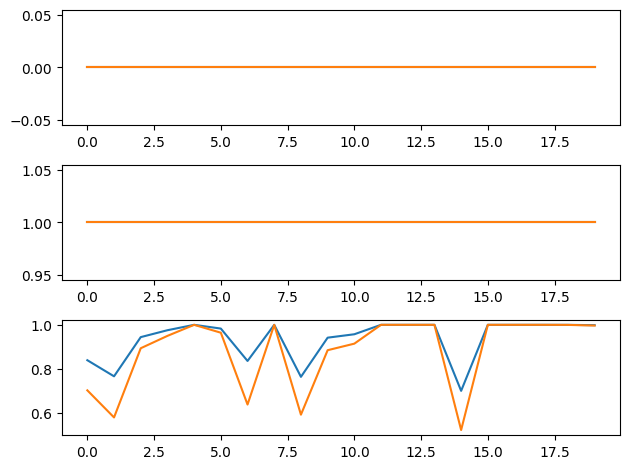

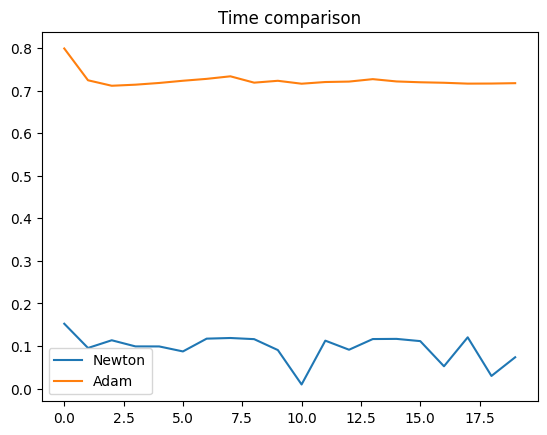

In [86]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(res_list[:, i, 0])
    plt.plot(res_list[:, i, 1])
plt.tight_layout()
plt.show()
plt.plot(time_list[:,1], label='Newton')
plt.plot(time_list[:,2], label='Adam')
plt.legend()
plt.title('Time comparison')
plt.show()

#### Gaussian blurred

In [91]:
def lim_var_mean(data, threshold=1, axis=0):
    """
    Compute the variance along a specified axis while eliminating 'outliers'
    threshold (float): The number of standard deviations to use for outlier detection.
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std_dev = np.std(data, axis=axis, keepdims=True)
    
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    
    mask = (data >= lower_bound) & (data <= upper_bound)
    filtered_data = np.where(mask, data, np.nan)
    
    variances = np.nanvar(filtered_data, axis=axis)
    means = np.nanmean(filtered_data, axis=axis)
    
    return variances, means

In [112]:
def grad_torch(func, x, ctx, *args):
    '''
    x is a row vector with one extra dimension [[a, b, c, ...]]
    returns the gradient as a row vector with same shape as x
    '''
    y, _ = func(x, ctx)
    # print(y, x)
    grad = torch.autograd.grad(y, x)[0]
    return grad

def grad_fd(func, x, ctx, epsilon=1e-6):
    '''
    To get gradient of a function using finite difference
    However, the smooth rendering function arleady has a forward pass that is the gradient instead of the actual function
    So we should treat the result of the func as the gradient, and not calculate its gradient again
    '''
    grad = torch.zeros_like(x)
    for i in range(x.size(0)):
        x_p = x.clone()
        x_n = x.clone()
        x_p[i] += epsilon
        x_n[i] -= epsilon
        y_p, _ = func(x_p, ctx)
        y_n, _ = func(x_n, ctx)
        grad[i] = (y_p - y_n) / 2 / epsilon
    return grad

def hessian_fd(func, x, ctx, grad_fn=grad_torch, epsilon=1e-4, device='cuda'):
    '''
    x is a row vector with one extra dimension [[a, b, c, ...]]
    '''
    new_x = x.clone()
    new_x = new_x.view(1,-1) # ensures a row vector
    n = new_x.size(1)
    hessian_matrix = torch.zeros((n, n), device=device)
        
    for i in range(n):
        # Perturb the i-th element
        x_pi = new_x.clone()
        x_ni = new_x.clone()
        x_pi[0,i] += epsilon
        x_ni[0,i] -= epsilon
        # Compute the gradient vectors at the perturbed point
        # thess will be the column vector df/dx_(1~n) dx_i
        par_pi = grad_fn(func, x_pi, ctx, epsilon)
        par_ni = grad_fn(func, x_ni, ctx, epsilon)
        # Compute the second-order partial derivatives
        hessian_matrix[i] =  (par_pi - par_ni) / 2 / epsilon
    
    # hessian_matrix[1,1] = 0
    # hessian_matrix[0,1] = 0
    # hessian_matrix[1,0] = 0
    return hessian_matrix.T

In [107]:
def f_smooth(perturbed_x, update_fn, ctx_args):
  with torch.no_grad():
      losses = []
      for j in range(perturbed_x.shape[0]):       # for each sample
        print(perturbed_x[j, :])
        perturbed_loss = f(perturbed_x[j, :])
        losses.append(perturbed_loss)

      avg_img = []
      loss = torch.stack(losses)
  return loss, avg_img

def f_smooth2(perturbed_x, update_fn, ctx_args):
  with torch.no_grad():
      loss = f(perturbed_x)
  return loss, []

device = 'cpu'
get_smoothed_loss = smoothFn(f_smooth2, device=device)

In [165]:
min_sample = 1
add_sample = 50
sigma = 0.01
sampler = 'uniform'
x = torch.tensor([0.5, 0.4], requires_grad=True, device=device)
number_of_samples = np.arange(min_sample, min_sample+add_sample, 1)
n = 1000
hess_fd_var = np.zeros((add_sample, 2, 2))
hess_fd_mean = np.zeros((add_sample, 2, 2))
hess_conv_var = np.zeros((add_sample, 2, 2))
hess_conv_mean = np.zeros((add_sample, 2, 2))
grad_var = np.zeros((2, add_sample))
grad_mean = np.zeros((2, add_sample))
for i in range(add_sample):
    print("Number of samples: ", number_of_samples[i])
    ctx_args = {'antithetic': True, 'nsamples': number_of_samples[i], 'sigma': 0.01,
                'sampler': sampler, 'device': device, 'update_fn': None}
    distribution_torch = np.zeros((n,2,2))
    distribution_conv = np.zeros((n,2,2))
    distribution_grad = np.zeros((2, n))
    start_time = time.time()
    for j in range(n):
        # distribution_conv[j,:,:] = smoothFn_hess(render_smooth, x.unsqueeze(0), context_args=ctx_args, device=ctx_args['device'], diag_approx=True).squeeze().cpu().detach().numpy()
        # hess_fd += hessian_fd(get_smoothed_loss, x.unsqueeze(0), ctx_args, grad_fn=grad_fd) # fd
        # hess_check += hessian_check(get_smoothed_loss, x.unsqueeze(0), ctx_args) # numdifftools
        distribution_torch[j,:,:] = hessian_fd(get_smoothed_loss, x.unsqueeze(0), ctx_args, grad_fn=grad_torch, device=device).squeeze().cpu().detach().numpy() # pytorch
        grad = grad_torch(get_smoothed_loss, x.unsqueeze(0), ctx_args)
        grad = grad.squeeze().cpu().detach().numpy()
        distribution_grad[:, j] = grad
    
    print("Time taken: ", time.time()-start_time)
    hess_fd_var[i, :, :] = np.var(distribution_torch, axis=0)
    grad_var[:, i] = np.var(distribution_grad, axis=1)
    hess_fd_mean[i, :, :] = np.mean(distribution_torch, axis=0)
    grad_mean[:, i] = np.mean(distribution_grad, axis=1)
    hess_conv_var[i, :, :] = np.var(distribution_conv, axis=0)
    hess_conv_mean[i, :, :] = np.mean(distribution_conv, axis=0)
    # hess_fd_var[i, :, :], hess_fd_mean[i, :, :] = lim_var_mean(distribution_torch, threshold=1, axis=0)
    # grad_var[:, i], grad_mean[:, i] = lim_var_mean(distribution_grad, threshold=3, axis=1)
    # hess_conv_var[i, :, :], hess_conv_mean[i, :, :] = lim_var_mean(distribution_conv, threshold=1, axis=0)


Number of samples:  1


Time taken:  2.7790310382843018
Number of samples:  2
Time taken:  2.700171947479248
Number of samples:  3
Time taken:  2.642143964767456
Number of samples:  4
Time taken:  2.7221028804779053
Number of samples:  5
Time taken:  2.6592273712158203
Number of samples:  6
Time taken:  2.7134556770324707
Number of samples:  7
Time taken:  2.6946792602539062
Number of samples:  8
Time taken:  2.7445998191833496
Number of samples:  9
Time taken:  2.7123374938964844
Number of samples:  10
Time taken:  2.7652857303619385
Number of samples:  11
Time taken:  2.703869104385376
Number of samples:  12
Time taken:  2.738325834274292
Number of samples:  13
Time taken:  2.6989150047302246
Number of samples:  14
Time taken:  2.746736764907837
Number of samples:  15
Time taken:  2.7407925128936768
Number of samples:  16
Time taken:  2.7867581844329834
Number of samples:  17
Time taken:  2.692440986633301
Number of samples:  18
Time taken:  2.7715718746185303
Number of samples:  19
Time taken:  2.730205774

In [166]:
diff = df(x.clone().detach().unsqueeze(0).numpy())
hess = hf(x.clone().detach().unsqueeze(0).numpy())
diff = np.tile(diff, (add_sample, 1, 1))
hess = np.tile(hess, (add_sample, 1, 1))

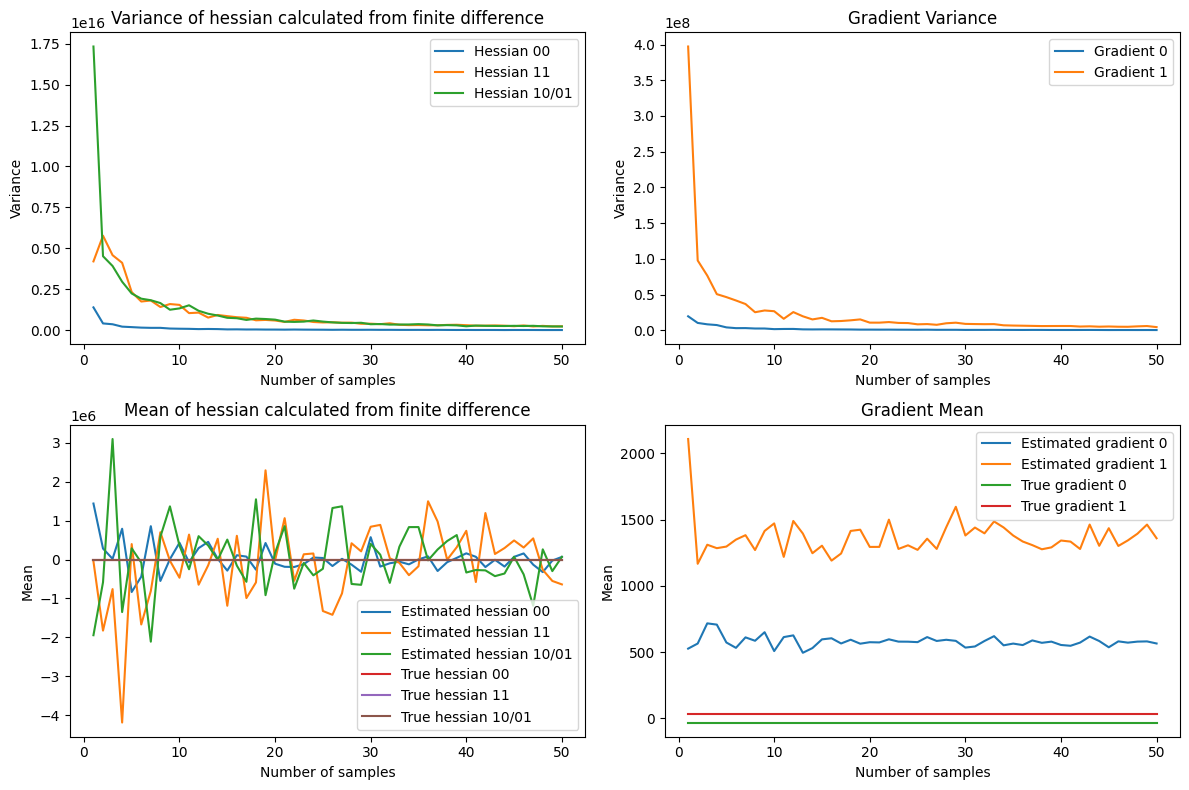

In [167]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_fd_var[:,0,0], label="Hessian 00")
plt.plot(number_of_samples, hess_fd_var[:,1,1], label="Hessian 11")
plt.plot(number_of_samples, hess_fd_var[:,1,0], label="Hessian 10/01")
plt.title("Variance of hessian calculated from finite difference")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_var[0,:], label="Gradient 0")
plt.plot(number_of_samples, grad_var[1,:], label="Gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.title("Gradient Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_fd_mean[:,0,0], label="Estimated hessian 00")
plt.plot(number_of_samples, hess_fd_mean[:,1,1], label="Estimated hessian 11")
plt.plot(number_of_samples, hess_fd_mean[:,1,0], label="Estimated hessian 10/01")
plt.plot(number_of_samples, hess[:,0,0], label="True hessian 00")
plt.plot(number_of_samples, hess[:,1,1], label="True hessian 11")
plt.plot(number_of_samples, hess[:,1,0], label="True hessian 10/01")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of hessian calculated from finite difference")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_mean[0,:], label="Estimated gradient 0")
plt.plot(number_of_samples, grad_mean[1,:], label="Estimated gradient 1")
plt.plot(number_of_samples, diff[:,0], label="True gradient 0")
plt.plot(number_of_samples, diff[:,1], label="True gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Gradient Mean")
plt.legend()
plt.tight_layout()
plt.show()


#### derive hessian IS

#### generate a convolved rosenbrock

  0%|          | 0/40000 [00:00<?, ?it/s]

100%|██████████| 40000/40000 [00:08<00:00, 4987.97it/s]


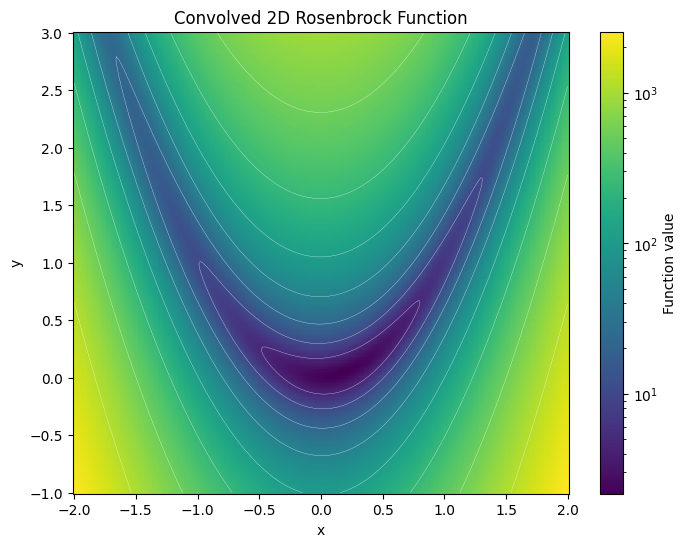

In [16]:
grid_size = 200
x1 = np.linspace(-2, 2, grid_size)
x2 = np.linspace(-1, 3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
y = np.zeros((grid_size*grid_size, 1))
for i, point in enumerate(tqdm(x)):
    convolved_value = convolve_function(f, gaussian_nd, torch.tensor([point]), n=100, sigma=0.1, sampler='grid')
    y[i] = convolved_value.detach().numpy()
y = y.reshape((grid_size,grid_size))

fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolor(X1, X2, y, norm=colors.LogNorm(vmin=y.min(), vmax=y.max()))
contour_levels = np.logspace(np.log10(y.min()), np.log10(y.max()), 10)
contours = ax.contour(X1, X2, y, levels=contour_levels, colors='white', linewidths=0.2)
# ax.clabel(contours, inline=True, fontsize=8)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Function value')
ax.set_title('Convolved 2D Rosenbrock Function')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [19]:
flatten_argmin = np.argmin(y)
argmin = np.unravel_index(flatten_argmin, (grid_size, grid_size))
print(x[argmin, np.arange(x.shape[1])])

[-0.95477387 -1.        ]


#### hess f hess g

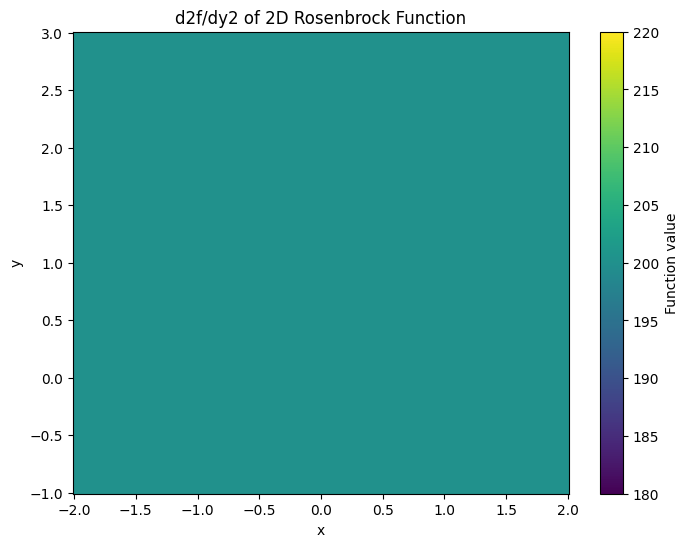

In [144]:
grid_size = 200
x1 = np.linspace(-2, 2, grid_size)
x2 = np.linspace(-1, 3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
y = hf(torch.tensor(x))[:,1,1].reshape((grid_size,grid_size))
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolor(X1, X2, y)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Function value')
ax.set_title('d2f/dy2 of 2D Rosenbrock Function')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

(10000, 2)


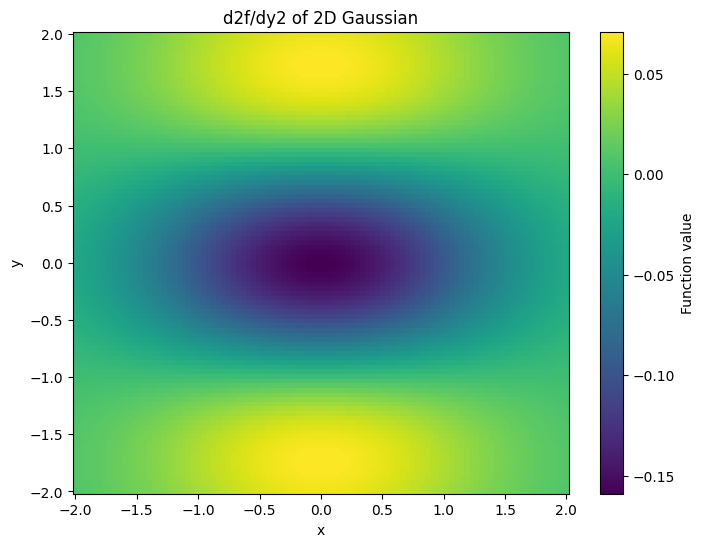

In [156]:
grid_size = 100
x1 = np.linspace(-2, 2, grid_size)
x2 = np.linspace(-2, 2, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
print(x.shape)
y = gaussiannd_hessian(torch.tensor(x, dtype=torch.float32))[:,1,1].reshape((grid_size,grid_size))
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolor(X1, X2, y)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Function value')
ax.set_title('d2f/dy2 of 2D Gaussian')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

#### test analytical on rosenbrock

In [172]:
min_sample = 1
add_sample = 20
sigma = 0.1
sampler = 'uniform'
x = torch.tensor([0.5, 0.4], requires_grad=True, device='cpu')
number_of_samples = np.arange(min_sample, min_sample+add_sample, 1)
n = 100
hess_conv_var = np.zeros((add_sample, 2, 2))
hess_conv_mean = np.zeros((add_sample, 2, 2))
grad_var = np.zeros((2, add_sample))
grad_mean = np.zeros((2, add_sample))
mi_grad_var = np.zeros((2, add_sample))
mi_grad_mean = np.zeros((2, add_sample))
for i in range(add_sample):
    print("Number of samples: ", number_of_samples[i])
    distribution_conv = np.zeros((n,2,2))
    distribution_grad = np.zeros((2, n))
    mi_grad = np.zeros((2, n))
    start_time = time.time()
    for j in range(n):
        distribution_conv[j,0,0] = convolve_hess(f, gaussiannd_hessian, x.unsqueeze(0), n=number_of_samples[i], dim=(0,0), sampler=sampler)
        distribution_conv[j,1,1] = convolve_hess(f, gaussiannd_hessian, x.unsqueeze(0), n=number_of_samples[i], dim=(1,1), sampler=sampler)
        distribution_conv[j,1,0] = convolve_hess(f, gaussiannd_hessian, x.unsqueeze(0), n=number_of_samples[i], dim=(1,0), sampler=sampler)
        distribution_conv[j,0,1] = distribution_conv[j,1,0]
        
        distribution_grad[:, j] = convolve_grad(f, gauss_grad, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler).detach().numpy()
        mi_grad[:, j] = convolve_grad(f, grad_of_gaussiankernel, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler).detach().numpy()
    print("Time taken: ", time.time()-start_time)
    hess_conv_var[i, :, :] = np.var(distribution_conv, axis=0)
    hess_conv_mean[i, :, :] = np.mean(distribution_conv, axis=0)
    grad_var[:, i] = np.var(distribution_grad, axis=1)
    grad_mean[:, i] = np.mean(distribution_grad, axis=1)
    mi_grad_var[:, i] = np.var(mi_grad, axis=1)
    mi_grad_mean[:, i] = np.mean(mi_grad, axis=1)



Number of samples:  1
Time taken:  0.2405557632446289
Number of samples:  2
Time taken:  0.29773640632629395
Number of samples:  3
Time taken:  0.36993408203125
Number of samples:  4
Time taken:  0.46908044815063477
Number of samples:  5
Time taken:  0.4666023254394531
Number of samples:  6
Time taken:  0.5307214260101318
Number of samples:  7
Time taken:  0.5741438865661621
Number of samples:  8
Time taken:  0.6308746337890625
Number of samples:  9
Time taken:  0.6935503482818604
Number of samples:  10
Time taken:  0.7439556121826172
Number of samples:  11
Time taken:  0.802788496017456
Number of samples:  12
Time taken:  0.88820481300354
Number of samples:  13
Time taken:  0.9913573265075684
Number of samples:  14
Time taken:  1.0734977722167969
Number of samples:  15
Time taken:  1.1958189010620117
Number of samples:  16
Time taken:  1.3206617832183838
Number of samples:  17
Time taken:  1.2576854228973389
Number of samples:  18
Time taken:  1.4131627082824707
Number of samples:  19

In [173]:
diff = df(x.clone().detach().unsqueeze(0))
hess = hf(x.clone().detach().unsqueeze(0))
diff = np.tile(diff, (add_sample, 1))
hess = np.tile(hess, (add_sample, 1, 1))

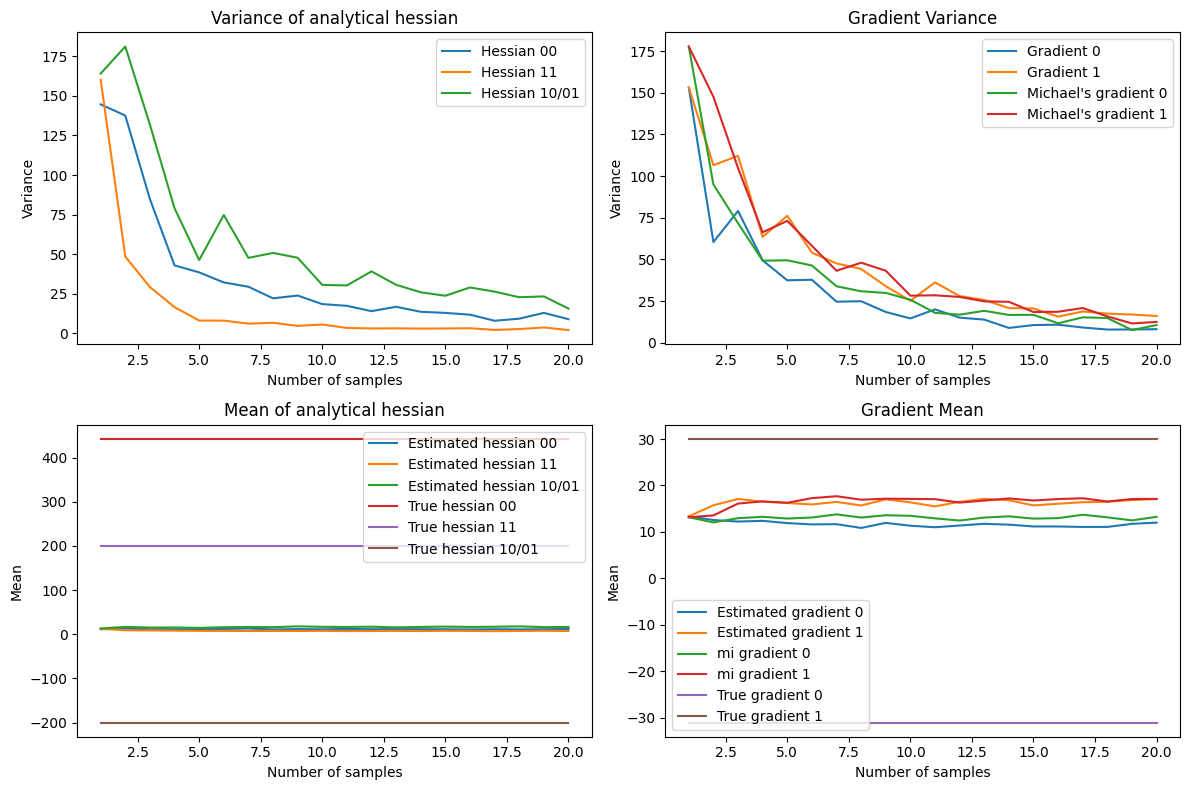

In [174]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_conv_var[:,0,0], label="Hessian 00")
plt.plot(number_of_samples, hess_conv_var[:,1,1], label="Hessian 11")
plt.plot(number_of_samples, hess_conv_var[:,1,0], label="Hessian 10/01")
plt.title("Variance of analytical hessian")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_var[0,:], label="Gradient 0")
plt.plot(number_of_samples, grad_var[1,:], label="Gradient 1")
plt.plot(number_of_samples, mi_grad_var[0,:], label="Michael's gradient 0")
plt.plot(number_of_samples, mi_grad_var[1,:], label="Michael's gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.title("Gradient Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_conv_mean[:,0,0], label="Estimated hessian 00")
plt.plot(number_of_samples, hess_conv_mean[:,1,1], label="Estimated hessian 11")
plt.plot(number_of_samples, hess_conv_mean[:,1,0], label="Estimated hessian 10/01")
plt.plot(number_of_samples, hess[:,0,0], label="True hessian 00")
plt.plot(number_of_samples, hess[:,1,1], label="True hessian 11")
plt.plot(number_of_samples, hess[:,1,0], label="True hessian 10/01")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical hessian")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_mean[0,:], label="Estimated gradient 0")
plt.plot(number_of_samples, grad_mean[1,:], label="Estimated gradient 1")
plt.plot(number_of_samples, mi_grad_mean[0,:], label="mi gradient 0")
plt.plot(number_of_samples, mi_grad_mean[1,:], label="mi gradient 1")
plt.plot(number_of_samples, diff[:,0], label="True gradient 0")
plt.plot(number_of_samples, diff[:,1], label="True gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Gradient Mean")
plt.legend()
plt.tight_layout()
plt.show()


#### test analytical on gaussian of gaussian

Analytical gaussian of convolved gaussian

Sampled convolved result of gaussian on gaussian

Test variance and bias

In [169]:
min_sample = 1
add_sample = 20

sampler = 'uniform'
x = torch.tensor([0.2, 0.1], requires_grad=True, device='cpu')
number_of_samples = np.arange(min_sample, min_sample+add_sample, 1)
n = 100
hess_conv_var = np.zeros((add_sample, 2, 2))
hess_conv_mean = np.zeros((add_sample, 2, 2))
grad_var = np.zeros((2, add_sample))
grad_mean = np.zeros((2, add_sample))
mi_grad_var = np.zeros((2, add_sample))
mi_grad_mean = np.zeros((2, add_sample))
for i in range(add_sample):
    print("Number of samples: ", number_of_samples[i])
    distribution_conv = np.zeros((n,2,2))
    distribution_grad = np.zeros((2, n))
    mi_grad = np.zeros((2, n))
    start_time = time.time()
    for j in range(n):
        
        distribution_conv[j,0,0] = convolve_hess_gauss(gaussian_nd, gaussiannd_hessian, x.unsqueeze(0), n=number_of_samples[i], dim=(0,0), sigma1=sigma1, sigma2=sigma2, sampler=sampler)
        distribution_conv[j,1,1] = convolve_hess_gauss(gaussian_nd, gaussiannd_hessian, x.unsqueeze(0), n=number_of_samples[i], dim=(1,1), sigma1=sigma1, sigma2=sigma2, sampler=sampler)
        distribution_conv[j,1,0] = convolve_hess_gauss(gaussian_nd, gaussiannd_hessian, x.unsqueeze(0), n=number_of_samples[i], dim=(1,0), sigma1=sigma1, sigma2=sigma2, sampler=sampler)
        distribution_conv[j,0,1] = distribution_conv[j,1,0]
        
        distribution_grad[:, j] = convolve_grad_gauss(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i], sigma1=sigma1, sigma2=sigma2, sampler=sampler).detach().numpy()
        mi_grad[:, j] = convolve_grad_gauss(gaussian_nd, grad_of_gaussiankernel, x.unsqueeze(0), n=number_of_samples[i], sigma1=sigma1, sigma2=sigma2, sampler=sampler).detach().numpy()
    print("Time taken: ", time.time()-start_time)
    hess_conv_var[i, :, :] = np.var(distribution_conv, axis=0)
    hess_conv_mean[i, :, :] = np.mean(distribution_conv, axis=0)
    grad_var[:, i] = np.var(distribution_grad, axis=1)
    grad_mean[:, i] = np.mean(distribution_grad, axis=1)
    mi_grad_var[:, i] = np.var(mi_grad, axis=1)
    mi_grad_mean[:, i] = np.mean(mi_grad, axis=1)



Number of samples:  1
Time taken:  0.2386159896850586
Number of samples:  2
Time taken:  0.2886652946472168
Number of samples:  3
Time taken:  0.34343981742858887
Number of samples:  4
Time taken:  0.39289045333862305
Number of samples:  5
Time taken:  0.452373743057251
Number of samples:  6
Time taken:  0.4981076717376709
Number of samples:  7
Time taken:  0.5489203929901123
Number of samples:  8
Time taken:  0.6027214527130127
Number of samples:  9
Time taken:  0.6495895385742188
Number of samples:  10
Time taken:  0.7082383632659912
Number of samples:  11
Time taken:  0.7624812126159668
Number of samples:  12
Time taken:  0.8567144870758057
Number of samples:  13
Time taken:  0.917834997177124
Number of samples:  14
Time taken:  0.9795470237731934
Number of samples:  15
Time taken:  1.0552942752838135
Number of samples:  16
Time taken:  1.230454921722412
Number of samples:  17
Time taken:  1.3163456916809082
Number of samples:  18
Time taken:  1.3376946449279785
Number of samples:  

In [170]:
# compute true grad and hess
diff = gauss_grad(x.clone().detach().unsqueeze(0), new_sigma)
hess = gaussiannd_hessian(x.clone().detach().unsqueeze(0), new_sigma)
diff = np.tile(diff, (add_sample, 1))
hess = np.tile(hess, (add_sample, 1, 1))

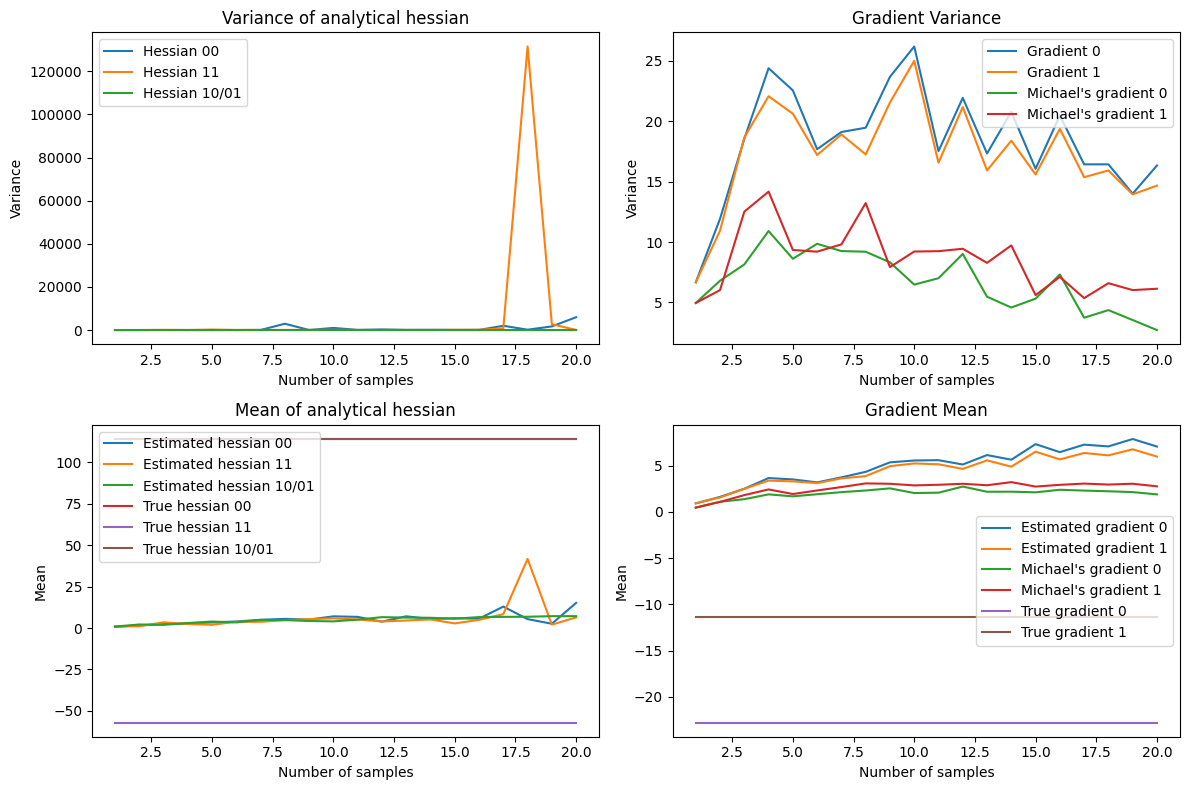

In [171]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_conv_var[:,0,0], label="Hessian 00")
plt.plot(number_of_samples, hess_conv_var[:,1,1], label="Hessian 11")
plt.plot(number_of_samples, hess_conv_var[:,1,0], label="Hessian 10/01")
plt.title("Variance of analytical hessian")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_var[0,:], label="Gradient 0")
plt.plot(number_of_samples, grad_var[1,:], label="Gradient 1")
plt.plot(number_of_samples, mi_grad_var[0,:], label="Michael's gradient 0")
plt.plot(number_of_samples, mi_grad_var[1,:], label="Michael's gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.title("Gradient Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_conv_mean[:,0,0], label="Estimated hessian 00")
plt.plot(number_of_samples, hess_conv_mean[:,1,1], label="Estimated hessian 11")
plt.plot(number_of_samples, hess_conv_mean[:,1,0], label="Estimated hessian 10/01")
plt.plot(number_of_samples, hess[:,0,0], label="True hessian 00")
plt.plot(number_of_samples, hess[:,1,1], label="True hessian 11")
plt.plot(number_of_samples, hess[:,1,0], label="True hessian 10/01")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical hessian")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_mean[0,:], label="Estimated gradient 0")
plt.plot(number_of_samples, grad_mean[1,:], label="Estimated gradient 1")
plt.plot(number_of_samples, mi_grad_mean[0,:], label="Michael's gradient 0")
plt.plot(number_of_samples, mi_grad_mean[1,:], label="Michael's gradient 1")
plt.plot(number_of_samples, diff[:,0], label="True gradient 0")
plt.plot(number_of_samples, diff[:,1], label="True gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Gradient Mean")
plt.legend()
plt.tight_layout()
plt.show()


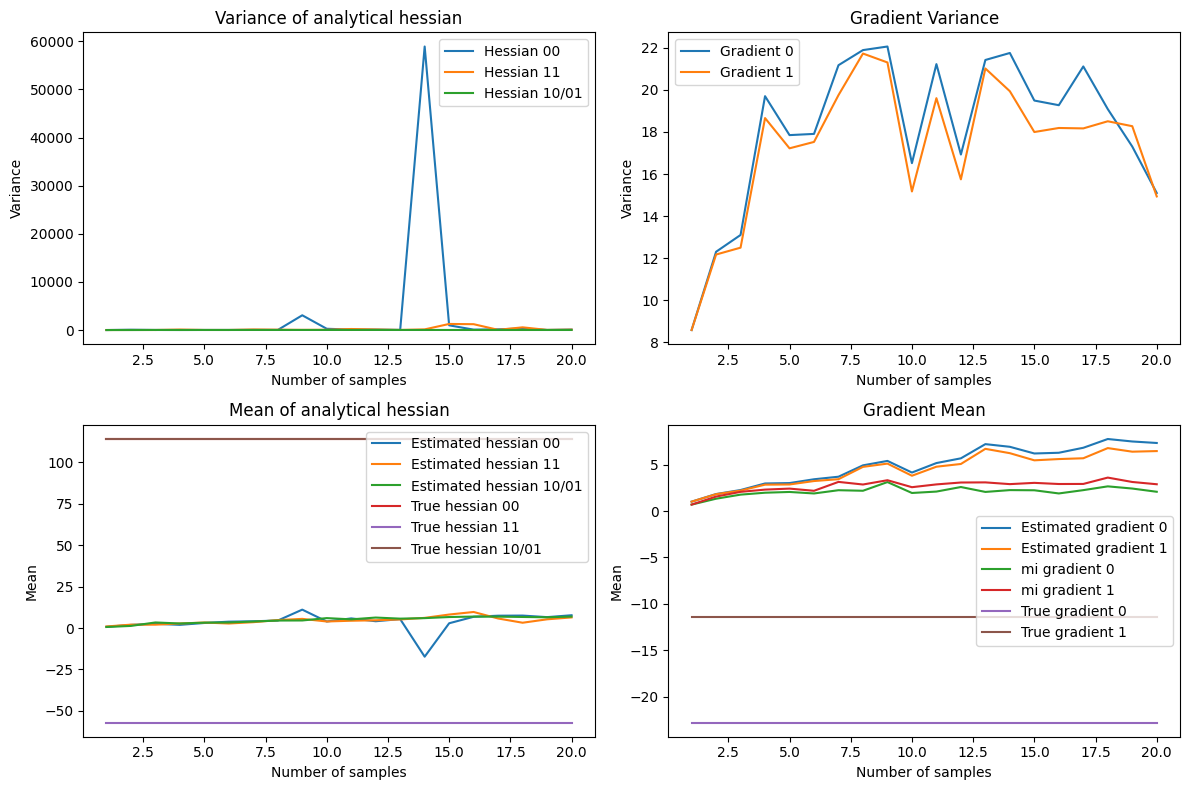

In [162]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_conv_var[:,0,0], label="Hessian 00")
plt.plot(number_of_samples, hess_conv_var[:,1,1], label="Hessian 11")
plt.plot(number_of_samples, hess_conv_var[:,1,0], label="Hessian 10/01")
plt.title("Variance of analytical hessian")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_var[0,:], label="Gradient 0")
plt.plot(number_of_samples, grad_var[1,:], label="Gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.title("Gradient Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_conv_mean[:,0,0], label="Estimated hessian 00")
plt.plot(number_of_samples, hess_conv_mean[:,1,1], label="Estimated hessian 11")
plt.plot(number_of_samples, hess_conv_mean[:,1,0], label="Estimated hessian 10/01")
plt.plot(number_of_samples, hess[:,0,0], label="True hessian 00")
plt.plot(number_of_samples, hess[:,1,1], label="True hessian 11")
plt.plot(number_of_samples, hess[:,1,0], label="True hessian 10/01")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical hessian")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_mean[0,:], label="Estimated gradient 0")
plt.plot(number_of_samples, grad_mean[1,:], label="Estimated gradient 1")
plt.plot(number_of_samples, mi_grad_mean[0,:], label="mi gradient 0")
plt.plot(number_of_samples, mi_grad_mean[1,:], label="mi gradient 1")
plt.plot(number_of_samples, diff[:,0], label="True gradient 0")
plt.plot(number_of_samples, diff[:,1], label="True gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Gradient Mean")
plt.legend()
plt.tight_layout()
plt.show()
